# Seq2Seq Transformer: French to English

Karl Heyer

This project was motivated by [fast.ai Lesson 11](http://course.fast.ai/lessons/lesson11.html) and a desire to understand the Transformer from [Attention Is All You Need](https://arxiv.org/pdf/1706.03762.pdf). fast.ai lesson 11 builds a seq2seq transformer for French to English translation using an LSTM based encoder/decoder model initialized with pretrained word vectors. I wanted to apply the same use of pretrained word vectors to a Transformer and expand the dataset used to train the model.

The data used comes from a [corpus](http://www.statmt.org/wmt15/translation-task.html) created by Chris Callison-Burch. The dataset was created by crawling english and french versions of web sites to create a parallel corpus. We will use the first 2 million sentence pairs from the dataset to train the model.

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.text import *
import fastText as ft

In [3]:
PATH = Path('data/translate')
TMP_PATH = PATH/'tmp'
TMP_PATH.mkdir(exist_ok=True)
fname='giga-fren.release2.fixed'
en_fname = PATH/f'{fname}.en'
fr_fname = PATH/f'{fname}.fr'

In [7]:
qs = pickle.load((PATH/'fr-en-all.pkl').open('rb'))

In [8]:
qs = qs[:2000000]

In [10]:
en_qs,fr_qs = zip(*qs)

The input text will be tokenized with spaCy tokenizers for English and French. For memory reasons we will only keep sentence pairs where the English sentence has less than 50 tokens.

In [12]:
en_tok = Tokenizer.proc_all_mp(partition_by_cores(en_qs))

In [13]:
fr_tok = Tokenizer.proc_all_mp(partition_by_cores(fr_qs), 'fr')

In [28]:
keep = np.array([len(o)<50 for o in en_tok])

In [29]:
keep.sum()

1826350

In [30]:
en_tok = np.array(en_tok)[keep]
fr_tok = np.array(fr_tok)[keep]

In [31]:
pickle.dump(en_tok, (PATH/'en_tok_all.pkl').open('wb'))
pickle.dump(fr_tok, (PATH/'fr_tok_all.pkl').open('wb'))

In [4]:
en_tok = pickle.load((PATH/'en_tok_all.pkl').open('rb'))
fr_tok = pickle.load((PATH/'fr_tok_all.pkl').open('rb'))

In [5]:
def toks2ids(tok,pre):
    freq = Counter(p for o in tok for p in o)
    itos = [o for o,c in freq.most_common(50000)]
    itos.insert(0, '_bos_')
    itos.insert(1, '_pad_')
    itos.insert(2, '_eos_')
    itos.insert(3, '_unk')
    stoi = collections.defaultdict(lambda: 3, {v:k for k,v in enumerate(itos)})
    ids = np.array([([stoi[o] for o in p] + [2]) for p in tok])
    np.save(TMP_PATH/f'{pre}_ids_all.npy', ids)
    pickle.dump(itos, open(TMP_PATH/f'{pre}_itos_all.pkl', 'wb'))
    return ids,itos,stoi

In [6]:
en_ids,en_itos,en_stoi = toks2ids(en_tok,'en')

In [7]:
fr_ids,fr_itos,fr_stoi = toks2ids(fr_tok,'fr')

In [4]:
def load_ids(pre):
    ids = np.load(TMP_PATH/f'{pre}_ids_all.npy')
    itos = pickle.load(open(TMP_PATH/f'{pre}_itos_all.pkl', 'rb'))
    stoi = collections.defaultdict(lambda: 3, {v:k for k,v in enumerate(itos)})
    return ids,itos,stoi

In [5]:
en_ids,en_itos,en_stoi = load_ids('en')
fr_ids,fr_itos,fr_stoi = load_ids('fr')

In [6]:
enlen_90 = int(np.percentile([len(o) for o in en_ids], 98))
frlen_90 = int(np.percentile([len(o) for o in fr_ids], 97))
enlen_90,frlen_90

(48, 56)

In [7]:
en_ids_tr = np.array([o[:enlen_90] for o in en_ids])
fr_ids_tr = np.array([o[:frlen_90] for o in fr_ids])

In [8]:
class Seq2SeqDataset(Dataset):
    def __init__(self, x, y): self.x,self.y = x,y
    def __getitem__(self, idx): return A(self.x[idx], self.y[idx])
    def __len__(self): return len(self.x)

In [9]:
np.random.seed(42)
trn_keep = np.random.rand(len(en_ids_tr))>0.1
en_trn,fr_trn = en_ids_tr[trn_keep],fr_ids_tr[trn_keep]
en_val,fr_val = en_ids_tr[~trn_keep],fr_ids_tr[~trn_keep]
len(en_trn),len(en_val)

(1643912, 182438)

In [10]:
trn_ds = Seq2SeqDataset(fr_trn,en_trn)
val_ds = Seq2SeqDataset(fr_val,en_val)

In [11]:
bs=64

In [12]:
trn_samp = SortishSampler(en_trn, key=lambda x: len(en_trn[x]), bs=bs)
val_samp = SortSampler(en_val, key=lambda x: len(en_val[x]))

In [13]:
trn_dl = DataLoader(trn_ds, bs, transpose=True, transpose_y=True, num_workers=1, 
                    pad_idx=1, pre_pad=False, sampler=trn_samp)
val_dl = DataLoader(val_ds, int(bs*1.6), transpose=True, transpose_y=True, num_workers=1, 
                    pad_idx=1, pre_pad=False, sampler=val_samp)
md = ModelData(PATH, trn_dl, val_dl)

In [14]:
it = iter(trn_dl)
its = [next(it) for i in range(5)]
[(len(x),len(y)) for x,y in its]

[(43, 23), (56, 38), (47, 23), (51, 32), (31, 15)]

# Transformer

Here is the Transformer model, in all it's glory. The code used here was taken from [The Annotated Transformer](http://nlp.seas.harvard.edu/2018/04/03/attention.html) by Alexander Rush and [How to Code the Transformer in PyTorch](https://blog.floydhub.com/the-transformer-in-pytorch/) by Samuel Lynn-Evans.

The first module is a simple embedding layer.

In [15]:
class Embedder(nn.Module):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, d_model)
    def forward(self, x):
        return self.embed(x)

The Transformer, having moved away from sequential models, needs a way understand where words are in a sentence. This is done through a positional encoder. The encoder models sentence position and length as a sine function.

In [16]:
class PositionalEncoder(nn.Module):
    def __init__(self, d_model, max_seq_len = 80):
        super().__init__()
        self.d_model = d_model

        pe = torch.zeros(max_seq_len, d_model)
        for pos in range(max_seq_len):
            for i in range(0, d_model, 2):
                pe[pos, i] = \
                math.sin(pos / (10000 ** ((2 * i)/d_model)))
                pe[pos, i + 1] = \
                math.cos(pos / (10000 ** ((2 * (i + 1))/d_model)))
                
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
 
    
    def forward(self, x):
        x = x * math.sqrt(self.d_model)
        seq_len = x.size(1)
        x = x + Variable(self.pe[:,:seq_len], \
        requires_grad=False).cuda()
        return x

This is the basic attention calculation, given by the following equation:

$$                                                                         
   \mathrm{Attention}(Q, K, V) = \mathrm{softmax}(\frac{QK^T}{\sqrt{d_k}})V               
$$      

Where Q, K and V stand for Query, Key and Value. In the encoder layers of the Transformer, Q, K and V all come from the encoder output of the previous layer, performing self-attention over the input sentence. In the decoder layers of the Transformer, the Query is the hidden state being decoded, while the Key and Value values come from the encoder. This means that every layer in the decoder performs attention on the final encoder output that represente the input sequence.

The attention function also incorporates masking into the attention function. Masking is an important concept in the Transformer. It controls what the model can see and when. For the input sequence, the mask used is a vector that contains 0s wherever the input sentence is padded. In the target sentence, the mask is a two dimensional matrix that masks over the entire target sentence one word at a time. The first row of the target mask masks every word but the first. The second row masks everything except the first two words. And so on until the final row that allows the model to see the entire sequence. This mimics forcing the model to look at one word at a time.

It is important to note though this occurrs entirely within the attention function and at the end of the model, only a single output prediction will be made.

In [17]:
def attention(q, k, v, d_k, mask=None, dropout=None):
    
    scores = torch.matmul(q, k.transpose(-2, -1)) /  math.sqrt(d_k)

    if mask is not None:
        mask = mask.unsqueeze(1)
        scores = scores.masked_fill(mask == 0, -1e9)
        
    scores = F.softmax(scores, dim=-1)
    
    if dropout is not None:
        scores = dropout(scores)
        
    output = torch.matmul(scores, v)
    return output

Things get a bit weird here. Before actually calculating attention over Q, K and V values, the input values are put through linear layers and broken into a several heads. Each head of the input is attended to separately, allowing the model to perform attention on many different representations of the input.

In [18]:
class MultiHeadAttention(nn.Module):
    def __init__(self, heads, d_model, dropout = 0.2):
        super().__init__()
        
        self.d_model = d_model
        self.d_k = d_model // heads
        self.h = heads
        
        self.q_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(d_model, d_model)
    
    def forward(self, q, k, v, mask=None):
        
        bs = q.size(0)
                
        k = self.k_linear(k).view(bs, -1, self.h, self.d_k)
        q = self.q_linear(q).view(bs, -1, self.h, self.d_k)
        v = self.v_linear(v).view(bs, -1, self.h, self.d_k)
        
        # transpose to get dimensions bs * h * sl * d_model
       
        k = k.transpose(1,2)
        q = q.transpose(1,2)
        v = v.transpose(1,2)

        scores = attention(q, k, v, self.d_k, mask, self.dropout)
        concat = scores.transpose(1,2).contiguous().view(bs, -1, self.d_model)
        output = self.out(concat)
    
        return output

This is a standard feed forward network that will be used in the encoder and decoder layers.

In [19]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=2048, dropout = 0.2):
        super().__init__() 
        # We set d_ff as a default to 2048
        self.linear_1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model)
    def forward(self, x):
        x = self.dropout(F.relu(self.linear_1(x)))
        x = self.linear_2(x)
        return x

Layer outputs are normalized before being passed to the next layer. The parameters $\alpha$ and $bias$ used in the calculation are learned.

In [20]:
class Norm(nn.Module):
    def __init__(self, d_model, eps = 1e-6):
        super().__init__()
    
        self.size = d_model
        # create two learnable parameters to calibrate normalisation
        self.alpha = nn.Parameter(torch.ones(self.size))
        self.bias = nn.Parameter(torch.zeros(self.size))
        self.eps = eps
    def forward(self, x):
        norm = self.alpha * (x - x.mean(dim=-1, keepdim=True)) \
        / (x.std(dim=-1, keepdim=True) + self.eps) + self.bias
        return norm

Here we define the individual layers of the encoder and the decoder. The encoder layer has one attention layer before a feed forward layer. Notice the inputs to the encoder attention are all the same thing.

The decoder layer has two attention layers before a feed forward layer. Notice the input to the first attention layer is the target sentence and the target mask. The input to the second attention layer includes the outputs from the encoder layer.

In [21]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout = 0.1):
        super().__init__()
        self.norm_1 = Norm(d_model)
        self.norm_2 = Norm(d_model)
        self.attn = MultiHeadAttention(heads, d_model)
        self.ff = FeedForward(d_model)
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)
        
    def forward(self, x, mask):
        x2 = self.norm_1(x)
        x = x + self.dropout_1(self.attn(x2,x2,x2,mask))
        x2 = self.norm_2(x)
        x = x + self.dropout_2(self.ff(x2))
        return x
    
class DecoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout=0.1):
        super().__init__()
        self.norm_1 = Norm(d_model)
        self.norm_2 = Norm(d_model)
        self.norm_3 = Norm(d_model)
        
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)
        self.dropout_3 = nn.Dropout(dropout)
        
        self.attn_1 = MultiHeadAttention(heads, d_model)
        self.attn_2 = MultiHeadAttention(heads, d_model)
        self.ff = FeedForward(d_model).cuda()
        
    def forward(self, x, e_outputs, src_mask, trg_mask):
        x2 = self.norm_1(x)
        x = x + self.dropout_1(self.attn_1(x2, x2, x2, trg_mask))
        x2 = self.norm_2(x)
        x = x + self.dropout_2(self.attn_2(x2, e_outputs, e_outputs, src_mask))
        x2 = self.norm_3(x)
        x = x + self.dropout_3(self.ff(x2))
        return x
    
def get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

Here we create the main Encoder and Decoder classes that will contain multiple encoder layers and decoder layers.

The setup of the decoder layer does somewhat bug me. The initial input to the Decoder, `trg`, is the output sentence the model is supposed to be predicting. On a certain level this just doesn't feel right to me. Will the model just learn to reproduce the target input? As I understand it, the masking of the output sentence is supposed to prevent the model from 'cheating', but it still seems odd to train your model with the output you expect.

In practice, I haven't seen an obvious difference in translation quality between predictions made by the model with target inputs and without. The people who came up with the model are way better at this stuff than I am, so I'll trust their design.

In [22]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, d_model, N, heads):
        super().__init__()
        self.N = N
        self.embed = Embedder(vocab_size, d_model)
        self.pe = PositionalEncoder(d_model)
        self.layers = get_clones(EncoderLayer(d_model, heads), N)
        self.norm = Norm(d_model)
    def forward(self, src, mask):
        x = self.embed(src)
        x = self.pe(x)
        for i in range(N):
            x = self.layers[i](x, mask)
        return self.norm(x)
    
class Decoder(nn.Module):
    def __init__(self, vocab_size, d_model, N, heads):
        super().__init__()
        self.N = N
        self.embed = Embedder(vocab_size, d_model)
        self.pe = PositionalEncoder(d_model)
        self.layers = get_clones(DecoderLayer(d_model, heads), N)
        self.norm = Norm(d_model)
    def forward(self, trg, e_outputs, src_mask, trg_mask):
        x = self.embed(trg)
        x = self.pe(x)
        for i in range(N):
            x = self.layers[i](x, e_outputs, src_mask, trg_mask)
        return self.norm(x)

And here we put everything together - the Encoder, the Decoder, and the final feed forward layer

In [23]:
class Transformer(nn.Module):
    def __init__(self, src_vocab, trg_vocab, d_model, N, heads):
        super().__init__()
        self.encoder = Encoder(src_vocab, d_model, N, heads)
        self.decoder = Decoder(trg_vocab, d_model, N, heads)
        self.out = nn.Linear(d_model, trg_vocab)
    def forward(self, src, trg, src_mask, trg_mask):
        e_outputs = self.encoder(src, src_mask)
        d_output = self.decoder(trg, e_outputs, src_mask, trg_mask)
        output = self.out(d_output)
        return output

A function for generating masks

In [24]:
def nopeak_mask(size):
    np_mask = np.triu(np.ones((1, size, size)), k=1).astype('uint8')
    np_mask =  Variable(torch.from_numpy(np_mask) == 0).cuda()

    return np_mask

def create_masks(src, trg):
    
    src_mask = (src != 1).unsqueeze(-2)

    if trg is not None:
        trg_mask = (trg != 1).unsqueeze(-2)
        size = trg.size(1) # get seq_len for matrix
        np_mask = nopeak_mask(size).cuda()

        trg_mask = trg_mask & np_mask
        
    else:
        trg_mask = None
        
    return src_mask, trg_mask

The loss function used for this model is standard cross entropy

In [25]:
def seq2seq_loss(input, target):
    sl,bs = target.size()
    sl_in,bs_in,nc = input.size()
    if sl>sl_in: input = F.pad(input, (0,0,0,0,0,sl-sl_in))
    input = input[:sl]
    return F.cross_entropy(input.view(-1,nc), target.view(-1))

The model requires four inputs - the source sentence, the source mask, the target sentence and the target mask. The easiest way to plug this into a fast.ai framework is to use a custom stepper.

In [26]:
class TransformStepper(Stepper):
    def step(self, xs, y, epoch):
        xtra = []
        
        src = V(xs[0].transpose(0, 1))
        trg = V(y.transpose(0, 1))
        
        trg_input = trg[:, :-1]
        targets = trg[:, 1:].contiguous()
        
        src_mask, trg_mask = create_masks(src, trg_input)
        
        output = self.m(src, trg_input, src_mask, trg_mask)
        
        
        if isinstance(output,tuple):
            output,*xtra = output
            
        self.opt.zero_grad()
        loss = raw_loss = self.crit(output, targets)
        
        if self.reg_fn:
            loss = self.reg_fn(output, xtra, raw_loss)
            
        loss.backward()
        
        if self.clip:  
            nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)
            
        self.opt.step()
        
        return raw_loss.data
    
    def evaluate(self, xs, y):
        src = V(xs[0].transpose(0, 1))
        trg = V(y.transpose(0, 1))
        
        trg_input = trg[:, :-1]
        targets = trg[:, 1:].contiguous()
        
        src_mask, trg_mask = create_masks(src, trg_input)
        
        preds = self.m(src, trg_input, src_mask, trg_mask)

        if isinstance(preds,tuple): preds=preds[0]
        return preds, self.crit(preds, targets)

# The Model

Here we create the model. We will use a `d_model` value of 300, as that corresponds to the fastText word vectors we will be using later. Experimentally I found using `heads = 10` performed better than 6 (with 7, 8 and 9 being unusable as d_model/heads must be an integer value). An encoder and decoder depth of `N = 6` was used by the original paper.

In [27]:
d_model = 300
heads = 10
N = 6

src_vocab = len(fr_itos)
trg_vocab = len(en_itos)
model = to_gpu(Transformer(src_vocab, trg_vocab, d_model, N, heads))

Initialize the model with a xavier uniform distribution

In [28]:
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

Now we set up our learner and away we go

In [29]:
opt_fn = partial(optim.Adam, betas=(0.9, 0.98))

In [30]:
learn = RNN_Learner(md, SingleModel(to_gpu(model)), opt_fn=opt_fn)

In [31]:
learn.crit = seq2seq_loss

 53%|████████████████████▊                  | 5101/9538 [09:08<07:56,  9.30it/s, loss=tensor(18.2513, device='cuda:0')]

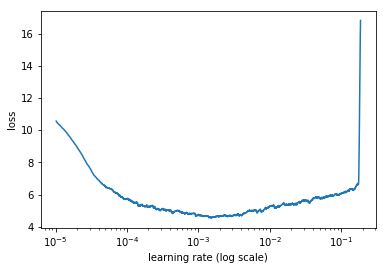

In [47]:
learn.lr_find(end_lr = 1000, stepper=TransformStepper)
learn.sched.plot()

In [34]:
lr = 1e-3

In [35]:
learn.fit(lr, 1, cycle_len=1, use_clr=(20,10), stepper=TransformStepper)

epoch      trn_loss   val_loss                                                                                         
    0      1.927851   2.254671  



[2.2546705476389852]

In [36]:
learn.save('transformer_10_6_v1')

In [37]:
learn.fit(lr/5, 1, cycle_len=10, use_clr=(20,10), stepper=TransformStepper, cycle_save_name='transformer_10_6')

epoch      trn_loss   val_loss                                                                                         
    0      1.794239   2.185134  
    1      1.710947   2.087145                                                                                         
    2      1.632631   2.031039                                                                                         
    3      1.632101   1.989288                                                                                         
    4      1.600255   1.954984                                                                                         
    5      1.734163   1.934943                                                                                         
    6      1.589054   1.911329                                                                                         
    7      1.56047    1.897814                                                                                         
    8  

[1.8837101832480982]

In [38]:
learn.save('transformer_10_6_v2')

The model has trained down nicely. Lets try some predictions.

In [39]:
x,y = next(iter(val_dl))

In [40]:
src = V(x.transpose(0, 1))
trg = V(y.transpose(0, 1))

trg_input = trg[:, :-1]
targets = trg[:, 1:].contiguous()

src_mask, trg_mask = create_masks(src, trg_input)

m = learn.model.eval()

output = m(src, trg_input, src_mask, trg_mask)

In [42]:
preds = to_np(F.softmax(output).max(2)[1])

In [44]:
for i in range(10,15):
    print(' '.join([fr_itos[o] for o in x[:,i] if o != 1]))
    print(' '.join([en_itos[o] for o in y[:,i] if o != 1]))
    print(' '.join([en_itos[o] for o in preds[i,:] if o!=1]))
    print()

le secteur du pressage et de la trituration des huiles en inde s' est donc retrouvé avec une grande capacité de production inutilisée ( le taux d' utilisation est estimé à seulement 35 % ) et le pays avec un déficit grandissant en approvisionnement en huiles comestibles , qui a été contrebalancé par les importations .
this situation has left india 's crushing and oil refining industry with large amounts of idle capacity ( utilization rate is estimated at only 35 % ) and the country with a burgeoning supply deficit in edible oils , which is balanced off with imports . 
 _eos_
resulted resulted been way 's pressing sector _eos_ crush force 's unused of unused output ( the is is estimated at only 35 % ) and has country 's growing edible deficit edible oils was offset was offset against against imports exceeding 
 _bos_

les détaillants mentionnent le bas niveau d’ achat des produits internationaux en comparaison aux produits chinois bien connus comme la raison de limiter l’ espace d’ étal

These predictions aren't that great. The model seems to do a good job of getting the general topic of the sentence it is translating, but the translations don't read well. The model seems to have a problem with repeating words. Then again the model is certainly better than just random guessing.

But the important thing to note is that these predictions were generated using the target sentence and target mask as input to the model. How will the model perform without those?

In [28]:
def subsequent_mask(size):
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

In [29]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    memory = model.encoder(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
    for i in range(max_len-1):
        out = model.decoder(Variable(ys), memory, src_mask, Variable(subsequent_mask(ys.size(1)).type_as(src.data)))
        prob = F.softmax(model.out(out[:, -1]))
        #_, next_word = torch.max(prob, dim = 1)
        next_word = torch.multinomial(prob, 1)
        next_word = next_word.data[0][0]
        ys = torch.cat([ys, 
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
    return ys

In [48]:
m = learn.model.eval()

In [52]:
ys = greedy_decode(m, src[10].unsqueeze(0), src_mask[10], enlen_90, 0)

In [53]:
print(' '.join([fr_itos[o] for o in x[:,10] if o != 1]))
print()
print(' '.join([en_itos[o] for o in y[:,10] if o != 1]))
print()
print(' '.join([en_itos[o] for o in ys[0] if o!=1]))
print()

le secteur du pressage et de la trituration des huiles en inde s' est donc retrouvé avec une grande capacité de production inutilisée ( le taux d' utilisation est estimé à seulement 35 % ) et le pays avec un déficit grandissant en approvisionnement en huiles comestibles , qui a été contrebalancé par les importations .

this situation has left india 's crushing and oil refining industry with large amounts of idle capacity ( utilization rate is estimated at only 35 % ) and the country with a burgeoning supply deficit in edible oils , which is balanced off with imports . 
 _eos_

_bos_ or oil demand growth in india has been adversely reduced because of the high production capacity ( i.e. from the use rate in only 35 per cent ) and the destination growing before _unk edible oils ( t_up cad _unk ) was higher . 
 _eos_



Honestly better than I expected. This translation is on par with the previous ones generated with the target sentence as input. My fear that the model would simply learn to copy the input target sentence seems overblown. Sure the translation is totally wrong, but it's as wrong as the translation with the target as input.

This particular translation is really interesting to read. The source sentence says that India's oil refineries are operating at low capacity due to a supply deficit - a lack of oil. The model's translation suggests that *demand* for oil has been reduced due to high production capacity. The model picked up on the concepts of low production utilization, but attributed that to high capacity rather than supply shortage. Perhaps the phrasing 'large amounts of idle capacity' gave the model the impression that capacity is large. The model also flipped the concept of supply to that of demand. Another neural net mystery.

# The Model With Pretraining

Now we're going to train the exact same model, but initialize the embedding layers with word vectors from fastText. Will this make the model better?

In [30]:
d_model = 300
heads = 10
N = 6

src_vocab = len(fr_itos)
trg_vocab = len(en_itos)
model = to_gpu(Transformer(src_vocab, trg_vocab, d_model, N, heads))

Initialize the model with a xavier uniform distribution

In [31]:
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

Now we add in fastText word vectors for English and French words in our vocabulary that are represented in fastText

In [32]:
en_vecs = ft.load_model(str((PATH/'wiki.en.bin')))
fr_vecs = ft.load_model(str((PATH/'wiki.fr.bin')))

In [37]:
def get_vecs(lang, ft_vecs):
    vecd = {w:ft_vecs.get_word_vector(w) for w in ft_vecs.get_words()}
    pickle.dump(vecd, open(PATH/f'wiki.{lang}.pkl','wb'))
    return vecd

In [38]:
en_vecd = get_vecs('en', en_vecs)
fr_vecd = get_vecs('fr', fr_vecs)

In [32]:
en_vecd = pickle.load(open(PATH/'wiki.en.pkl','rb'))
fr_vecd = pickle.load(open(PATH/'wiki.fr.pkl','rb'))

In [33]:
miss = []
for i,w in enumerate(fr_itos):
    try: model.encoder.embed.embed.weight.data[i] = V(torch.from_numpy(fr_vecd[w]), requires_grad=True)
    except: miss.append(w)

In [34]:
len(miss)

9147

In [35]:
miss = []
for i,w in enumerate(en_itos):
    try: model.encoder.embed.embed.weight.data[i] = V(torch.from_numpy(en_vecd[w]), requires_grad=True)
    except: miss.append(w)

In [36]:
len(miss)

10641

So about 20% of our vocabulary wasn't represented in fastText, but that's fine.

In [37]:
opt_fn = partial(optim.Adam, betas=(0.9, 0.98))

In [38]:
learn = RNN_Learner(md, SingleModel(to_gpu(model)), opt_fn=opt_fn)

In [39]:
learn.crit = seq2seq_loss

 53%|███████████████████▊                 | 13713/25687 [44:43<39:03,  5.11it/s, loss=tensor(15.5303, device='cuda:0')]

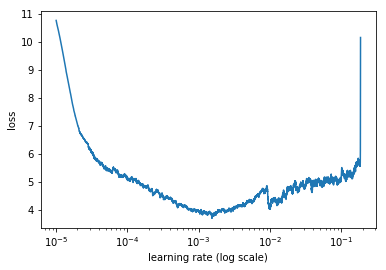

In [63]:
learn.lr_find(end_lr = 1000, stepper=TransformStepper)
learn.sched.plot()

In [40]:
lr = 1e-3

In [65]:
learn.fit(lr, 1, cycle_len=1, use_clr=(20,10), stepper=TransformStepper)

epoch      trn_loss   val_loss                                                                                         
    0      1.839402   2.244855  


[2.24485490753874]

In [66]:
learn.save('transformer_10_6_pre_v1')

In [41]:
learn.load('transformer_10_6_pre_v1')

In [42]:
learn.fit(lr/5, 1, cycle_len=10, use_clr=(20,10), stepper=TransformStepper, cycle_save_name='transformer_10_6_pre')

epoch      trn_loss   val_loss                                                                                         
    0      1.826812   2.169857  
    1      1.69769    2.071146                                                                                         
    2      1.623587   2.012601                                                                                         
    3      1.55745    1.970936                                                                                         
    4      1.561492   1.938948                                                                                         
    5      1.532702   1.907762                                                                                         
    6      1.669025   1.896485                                                                                         
    7      1.531949   1.877373                                                                                         
    8  

[1.8636644344632247]

In [43]:
learn.save('transformer_10_6_pre_v2')

Using pretrained word vectors doesn't seem to have had much of an effect here. The final validation loss for this model is 1.86, down from 1.88.

In [45]:
x,y = next(iter(val_dl))

In [46]:
src = V(x.transpose(0, 1))
trg = V(y.transpose(0, 1))

trg_input = trg[:, :-1]
targets = trg[:, 1:].contiguous()

src_mask, trg_mask = create_masks(src, trg_input)

m = learn.model.eval()

output = m(src, trg_input, src_mask, trg_mask)

In [47]:
preds = to_np(F.softmax(output).max(2)[1])

In [48]:
for i in range(10,15):
    print(' '.join([fr_itos[o] for o in x[:,i] if o != 1]))
    print(' '.join([en_itos[o] for o in y[:,i] if o != 1]))
    print(' '.join([en_itos[o] for o in preds[i,:] if o!=1]))
    print()

le secteur du pressage et de la trituration des huiles en inde s' est donc retrouvé avec une grande capacité de production inutilisée ( le taux d' utilisation est estimé à seulement 35 % ) et le pays avec un déficit grandissant en approvisionnement en huiles comestibles , qui a été contrebalancé par les importations .
this situation has left india 's crushing and oil refining industry with large amounts of idle capacity ( utilization rate is estimated at only 35 % ) and the country with a burgeoning supply deficit in edible oils , which is balanced off with imports . 
 _eos_
resulted has resulted itself 's oil sector oil crush sector great unused of production utilization rate is estimated at only 35 % ) , has country has growing growing deficit deficit in edible oils which which has imports against by imports per 
 _bos_

les détaillants mentionnent le bas niveau d’ achat des produits internationaux en comparaison aux produits chinois bien connus comme la raison de limiter l’ espace d

The predictions seem about the same as before

In [49]:
m = learn.model.eval()

In [50]:
ys = greedy_decode(m, src[10].unsqueeze(0), src_mask[10], enlen_90, 0)

In [51]:
print(' '.join([fr_itos[o] for o in x[:,10] if o != 1]))
print()
print(' '.join([en_itos[o] for o in y[:,10] if o != 1]))
print()
print(' '.join([en_itos[o] for o in ys[0] if o!=1]))
print()

le secteur du pressage et de la trituration des huiles en inde s' est donc retrouvé avec une grande capacité de production inutilisée ( le taux d' utilisation est estimé à seulement 35 % ) et le pays avec un déficit grandissant en approvisionnement en huiles comestibles , qui a été contrebalancé par les importations .

this situation has left india 's crushing and oil refining industry with large amounts of idle capacity ( utilization rate is estimated at only 35 % ) and the country with a burgeoning supply deficit in edible oils , which is balanced off with imports . 
 _eos_

_bos_ and affected using oil oils grown in india was then found to us with great anywhere in balance ( use is estimated at only 35 % ) and the country has become growing deficit in edible oils and gm imports . 
 _eos_



In [56]:
j = 30
ys = greedy_decode(m, src[j].unsqueeze(0), src_mask[10], enlen_90, 0)

In [57]:
print(' '.join([fr_itos[o] for o in x[:,j] if o != 1]))
print()
print(' '.join([en_itos[o] for o in y[:,j] if o != 1]))
print()
print(' '.join([en_itos[o] for o in ys[0] if o!=1]))
print()

selon le professeur hamm de l' université de _unk , il pourrait devenir nécessaire pour les fournisseurs allemands d' aliments biologiques de recourir à l' importation de l' amérique latine ou du canada , mais , pour de nombreux adeptes , cela serait contraire au principe de la consommation de produits saisonniers produits localement de manière

_unk university 's hamm said germany 's organic food suppliers may have to fall back on imports from latin america or canada but for many fans this runs contrary to the philosophy of using seasonal foods grown close to home and in harmony with nature . 
 _eos_

_bos_ holds an at university of _unk that might be necessary for german organic food suppliers to use imports of latin america or canada , but not many gm oriented products in this manner should be reasonable to demand in the economy . 
 _eos_

